# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

Exploratory data analysis of this dataset is covered in ```EDA.ipynb```.

The goal of this notebook is to try out some simple ML models and test best ML practices using a straightforward dataset. This includes
- Apply regression models (Linear, Ridge and Lasso) to predict house prices.
- Perform k-fold cross validation.
- Evaluate model performance with all available metrics: ROC/ AUC curves, accuracy, precision, F1-score, R^2, MSE, RMSE, NMSE confusion matrices.
- Perform hyperparameter tuning with GridSearchCV and RandomSearchCV to optimize models.
- Determine the best regression model for price prediction.
- Convert categorical data to numerical data.
- Evaluate the effect of scaling/ normalization on model performance.
- Automate model building with pipelines.
- Principal component analysis - [Geeksforgeeks](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-with-python/)

Repository link: [Github](https://github.com/rsamconn/London-housing)

**Functions created:**
1. _score_predict_plot()_ - takes in a dictionary of models, scores them and prints the predictions.
2. _multi_cross_val_score()_ - takes in a dictionary of models prints their min--mean--max scores over multiple data folds.
3. _evaluate_CVs()_ - takes in a dictionary of models, prints their best scores and parameters and saves these results.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.NaN)

nan


In [3]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## Planning

I will run Regression models for several different 'passes' which each use different feature datasets.

Each pass gets these steps:

1. Determine input data
2. Import, instantiate, and fit models - linear, lasso, ridge
3. Predicting target variables
4. Evaluating predictions vs. test data
5. K-fold cross validation
6. Hyperparameter tuning
7. Pipeline for best model

Afterwards I can do more advanced things - scaling, categorical -> numeric, other metrics, PCA

Input data ideas:

- [x] Pass 1 = only square meters
- [x] Pass 2 = only numeric data
- [x] Pass 3 = numeric data plus some categoric data converted to numeric - only the Neighborhood column
- [] Pass 4 = _all_ data
- [] Final pass = use only the top features from PCA

Other ideas: add price per square meter column, add other features?

In [4]:
from sklearn.model_selection import train_test_split

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## -------------------- Pass 1 - Only Square Meters --------------------
1. Get data
2. Simple test models - pick 1 hyperparam, instantiate, fit, score, predict and plot predictions
3. k-fold cross validation - setup k-Fold data, apply `cross_val_score`, boxplot the results
4. Hyperparameter tuning - setup param grids, setup RandomizedSearchCV object, fit, print score, best score and best params

### 1.1 Get data

In [5]:
# Create sqm-only dataset
X_sqm = housing_df['Square Meters'].values.reshape(-1, 1)
y = housing_df['Price (£)'].values
X_train_sqm, X_test_sqm, y_train_sqm, y_test_sqm = train_test_split(X_sqm, y, test_size=0.3, random_state=24)

print(X_train_sqm.shape, X_test_sqm.shape, y_train_sqm.shape, y_test_sqm.shape)

(700, 1) (300, 1) (700,) (300,)


### 1.2 Simple models

#### 1.2.1 Instantiate and fit

In [6]:
# Instantiate models
linreg1 = LinearRegression()
lasso1 = Lasso(alpha = 0.1)
ridge1 = Ridge(alpha = 0.1)

# Fit to numeric data
linreg1.fit(X_train_sqm, y_train_sqm)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [7]:
lasso1.fit(X_train_sqm, y_train_sqm)


,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [8]:
ridge1.fit(X_train_sqm, y_train_sqm)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [9]:
# Create a model dictionary
models_sqm = {
    'Linear Regression': linreg1,
    'Lasso': lasso1,
    'Ridge': ridge1
}

#### 1.2.2 Predict and plot

In [10]:
def score_predict_plot(model_dict,
                       X_train, y_train, X_test, y_test, X_test1D,
                       title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', color='black', alpha=0.9, s=20)
    
    # Loop over models and plot their restults
    for model_name, model in model_dict.items():
        
        y_pred = model.predict(X_test)

        # Plot predicted results
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)

        print(f"{model_name} training--testing R²: {model.score(X_train, y_train):.4f}--{model.score(X_test, y_test):.4f}")
        
    plt.xlabel('Square meters [m^2]', fontsize=11)
    plt.ylabel('Price [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Linear Regression training--testing R²: 0.6391--0.5912
Lasso training--testing R²: 0.6391--0.5912
Ridge training--testing R²: 0.6391--0.5912


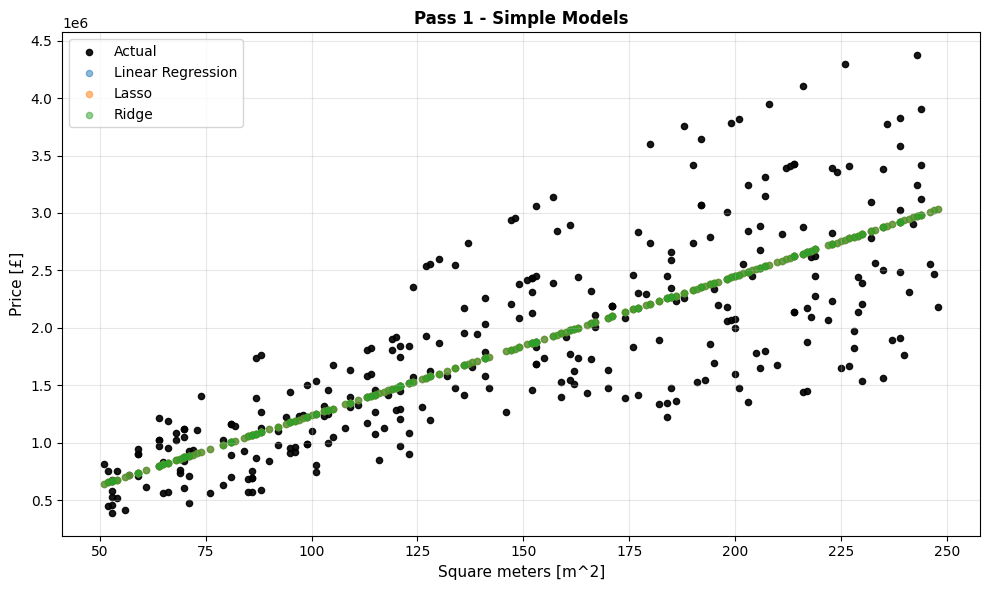

In [11]:
score_predict_plot(models_sqm,
                   X_train_sqm, y_train_sqm, X_test_sqm, y_test_sqm, X_test_sqm,
                   title='Pass 1 - Simple Models')

### 1.3 Cross validation

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

In [12]:
# Create k-fold object
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
kf5 = KFold(n_splits=5, shuffle=True, random_state=24)
kf10 = KFold(n_splits=10, shuffle=True, random_state=24)

In [13]:
def multi_cross_val_score(models, X, y, kf):
    """Function to return cross-validation scores for multiple models."""
    cross_val_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf)
        cross_val_scores[name] = scores
        print(f'{name} cross-validation scores: {np.round(np.min(scores), 3)} --- {np.round(np.mean(scores), 3)} --- {np.round(np.max(scores), 3)}')
    return cross_val_scores

In [14]:
cross_vals_sqm = multi_cross_val_score(
    models = {'Linear Regression': linreg1, 'Lasso': lasso1, 'Ridge': ridge1},
    X = X_train_sqm,
    y = y_train_sqm,
    kf = kf10
)

Linear Regression cross-validation scores: 0.526 --- 0.63 --- 0.698
Lasso cross-validation scores: 0.526 --- 0.63 --- 0.698
Ridge cross-validation scores: 0.526 --- 0.63 --- 0.698


In [15]:
cross_vals_sqm = multi_cross_val_score(
    models = {'Linear Regression': linreg1, 'Lasso': lasso1, 'Ridge': ridge1},
    X = X_test_sqm,
    y = y_test_sqm,
    kf = kf10
)

Linear Regression cross-validation scores: 0.382 --- 0.555 --- 0.695
Lasso cross-validation scores: 0.382 --- 0.555 --- 0.695
Ridge cross-validation scores: 0.382 --- 0.555 --- 0.695


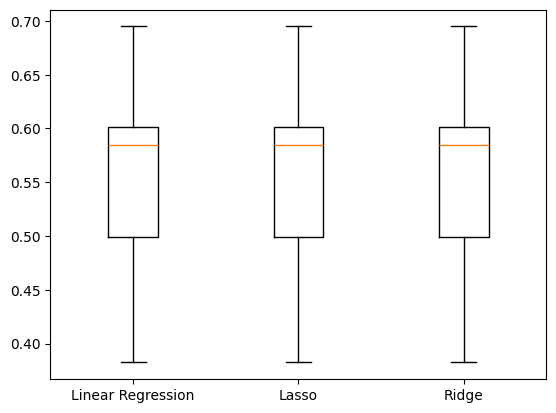

In [16]:
plt.boxplot(
    [model_result for model_result in cross_vals_sqm.values()],
    labels = [model_name for model_name in cross_vals_sqm.keys()]
)
plt.show()

### 1.4 Hyperparameter tuning

Function to fit and evaluates CV objects.

In [17]:
def evaluate_CVs(models, X_train, y_train):
    '''Fit CV objects from a dictionary.
    Print best scores and parameters and save them to a new dict.'''
    results_dict = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        print('{} {} {}'.format(5*'-', name, 5*'-'))
        # print(f'{name} score: {model.score(X, y)}')
        print(f'Top score: {model.best_score_:.4f}')
        print(f'Top params: {model.best_params_}')
        results_dict[name] = [model.best_score_, model.best_params_]
    return results_dict

In [18]:
lasso_params = {'alpha': np.linspace(0.001, 10)}
ridge_params = {'alpha': np.linspace(0.001, 10),
                'solver': ['sag', 'lsqr']}

Instantiate Models

In [19]:
# Instantiate GridSearchCVs
gridCV_lasso1 = GridSearchCV(lasso1, lasso_params, cv=kf10)
gridCV_ridge1 = GridSearchCV(ridge1, ridge_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso1 = RandomizedSearchCV(lasso1, lasso_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge1 = RandomizedSearchCV(ridge1, ridge_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_sqm = {'Lasso GridSearchCV': gridCV_lasso1, 
            'Ridge GridSearchCV': gridCV_ridge1,
            'Lasso RandomizedSearchCV': randomCV_lasso1, 
            'Ridge RandomizedSearchCV': randomCV_ridge1,}

Evaluate models

In [20]:
cv_results_sqm = evaluate_CVs(cvs_sqm, X_train_sqm, y_train_sqm)

----- Lasso GridSearchCV -----
Top score: 0.6296
Top params: {'alpha': 10.0}
----- Ridge GridSearchCV -----
Top score: 0.6297
Top params: {'alpha': 9.387816326530613, 'solver': 'sag'}
----- Lasso RandomizedSearchCV -----
Top score: 0.6296
Top params: {'alpha': 8.163448979591838}
----- Ridge RandomizedSearchCV -----
Top score: 0.6297
Top params: {'solver': 'sag', 'alpha': 2.653795918367347}


### 1.5 Scaling
Can the score be increased through Standard Scaling?

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps_sqm = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge1 = Pipeline(steps_sqm)

ridge1_scaled = pipeline_ridge1.fit(X_train_sqm, y_train_sqm)

In [22]:
ridge1_scaled.score(X_test_sqm, y_test_sqm)

0.5913154197136332

Adding in CVs

In [23]:
lasso_params2 = {'alpha': np.linspace(0.0001, 1, 10)}
ridge_params2 = {'ridge__alpha': np.linspace(0.0001, 1, 10),
                'ridge__solver': ['sag', 'lsqr']}

In [24]:
# Instantiate GridSearchCVs
gridCV_ridge1_scaled = GridSearchCV(ridge1_scaled, param_grid=ridge_params2, cv=kf10)
# Fit GridSearchCVs
gridCV_ridge1_scaled.fit(X_train_sqm, y_train_sqm)

# Score GridSearchCV models
print(f'Ridge score: {gridCV_ridge1_scaled.score(X_test_sqm, y_test_sqm)}')
print(f'Scaled Ridge GridSearchCV top score: {gridCV_ridge1_scaled.best_score_} from {gridCV_ridge1_scaled.best_params_}')

Ridge score: 0.5913037627574789
Scaled Ridge GridSearchCV top score: 0.6296650144968722 from {'ridge__alpha': 1.0, 'ridge__solver': 'sag'}


### 1.6 Pass 1 - Summary
What have we learned?

1. Simple models: each of Linear, Lasso and Ridge Regression each get 59% accuracy --> Quite poor
    - Each model seems to be making exactly the same predictions
2. 5-Fold cross-validation: the scores range from 59-66% (average 63%)
3. 10-Fold cross-validation: the scores range from 53-70% (average 63%)
4. GridSearchCV over alpha: best parameters get 63% at alpha=1 (Ridge and Lasso are equal, RandomizedSearchCV gives basically the same results)
5. Nothing gained from scaling

## -------------------- Pass 2 - Numeric data --------------------
Now include the numbers of bedrooms, bathrooms, floors and the building age in the feature set.

### 2.1 Get Data

In [25]:
# Create numeric-only dataset
numeric_columns = ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']
X_numeric = housing_df.loc[:, numeric_columns].values
y = housing_df['Price (£)'].values
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y, test_size=0.3, random_state=24)

print(X_train_numeric.shape, X_test_numeric.shape, y_train_numeric.shape, y_test_numeric.shape)

(700, 5) (300, 5) (700,) (300,)


### 2.2 Simple Models

#### 2.2.1 Import, instantiate, fit

Linear, lasso and ridge regression model

In [26]:
# Instantiate models
linreg_num = LinearRegression()
lasso_num = Lasso(alpha = 0.1)
ridge_num = Ridge(alpha = 0.1)

# Fit to numeric data
linreg_num.fit(X_train_numeric, y_train_numeric)
lasso_num.fit(X_train_numeric, y_train_numeric)
ridge_num.fit(X_train_numeric, y_train_numeric)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [27]:
# Create a dictionary of numeric models
models_numeric = {
    'Linear Regression': linreg_num,
    'Lasso': lasso_num,
    'Ridge': ridge_num
}

#### 2.2.2 Predict

Linear Regression training--testing R²: 0.6400--0.5901
Lasso training--testing R²: 0.6400--0.5901
Ridge training--testing R²: 0.6400--0.5901


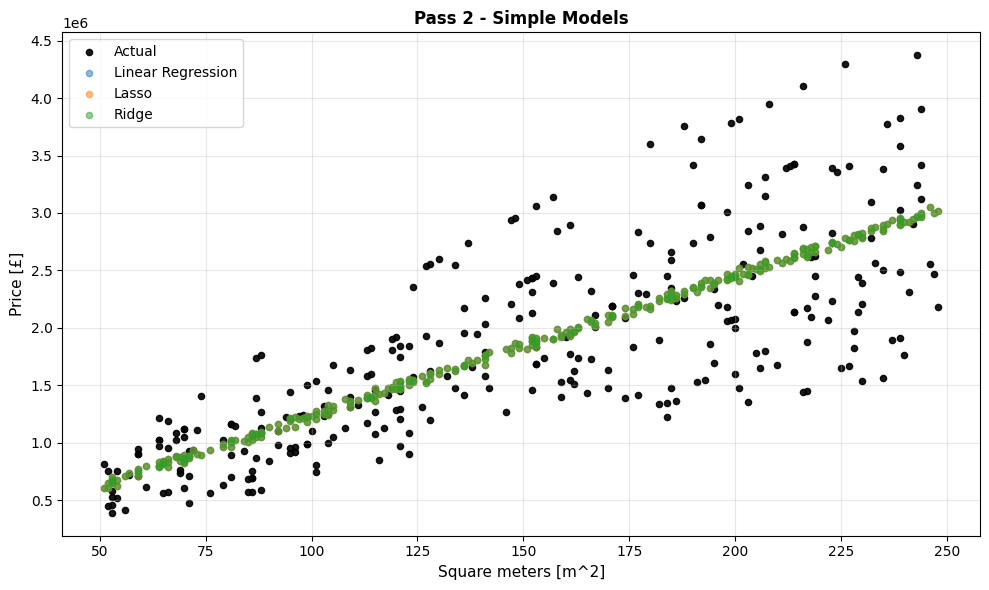

In [28]:
score_predict_plot(models_numeric,
                   X_train_numeric, y_train_numeric, X_test_numeric, y_test_numeric,
                   X_test_sqm, title='Pass 2 - Simple Models')

### 2.3 Cross validation - Numeric

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

Training set scores

In [29]:
cross_vals_num = multi_cross_val_score(
    models = models_numeric,
    X = X_train_numeric,
    y = y_train_numeric,
    kf = kf10
)

Linear Regression cross-validation scores: 0.526 --- 0.627 --- 0.698
Lasso cross-validation scores: 0.526 --- 0.627 --- 0.698
Ridge cross-validation scores: 0.526 --- 0.627 --- 0.698


Test set scores

In [30]:
cross_vals_num = multi_cross_val_score(
    models = models_numeric,
    X = X_test_numeric,
    y = y_test_numeric,
    kf = kf10
)

Linear Regression cross-validation scores: 0.362 --- 0.547 --- 0.685
Lasso cross-validation scores: 0.362 --- 0.547 --- 0.685
Ridge cross-validation scores: 0.362 --- 0.547 --- 0.685


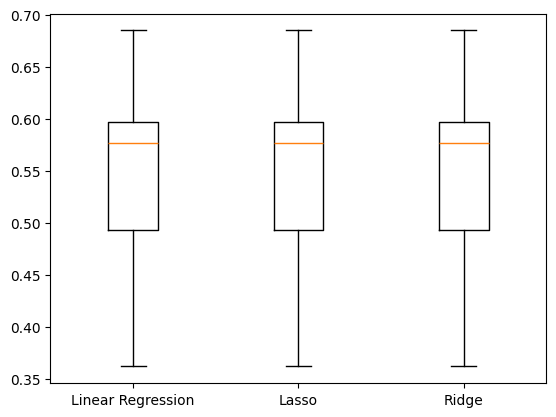

In [31]:
plt.boxplot(
    [model_result for model_result in cross_vals_num.values()],
    labels = [model_name for model_name in cross_vals_num.keys()]
)
plt.show()

### 2.4 Hyperparameter Tuning - Numeric
Run GridSearchCV and RandomizedSearchCV on the numeric models.

In [32]:
lasso_params2 = {'alpha': np.linspace(0.001, 100, 20)}
ridge_params2 = {'alpha': np.linspace(0.001, 100, 20),
                'solver': ['sag', 'lsqr']}

In [33]:
# Instantiate GridSearchCVs
gridCV_lasso_num = GridSearchCV(lasso_num, lasso_params2, cv=kf10)
gridCV_ridge_num = GridSearchCV(ridge_num, ridge_params2, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_num = RandomizedSearchCV(lasso_num, lasso_params2, cv=kf10, n_iter=20, random_state=24)
randomCV_ridge_num = RandomizedSearchCV(ridge_num, ridge_params2, cv=kf10, n_iter=20, random_state=24)
# Save models to dictionary
cvs_num = {'Lasso GridSearchCV': gridCV_lasso_num,
           'Ridge GridSearchCV': gridCV_ridge_num,
           'Lasso RandomizedSearchCV': randomCV_lasso_num, 
           'Ridge RandomizedSearchCV': randomCV_ridge_num,}

In [34]:
cv_results_num = evaluate_CVs(cvs_num, X_train_numeric, y_train_numeric)

----- Lasso GridSearchCV -----
Top score: 0.6267
Top params: {'alpha': 100.0}
----- Ridge GridSearchCV -----
Top score: 0.6271
Top params: {'alpha': 100.0, 'solver': 'lsqr'}
----- Lasso RandomizedSearchCV -----
Top score: 0.6267
Top params: {'alpha': 100.0}
----- Ridge RandomizedSearchCV -----
Top score: 0.6271
Top params: {'solver': 'lsqr', 'alpha': 100.0}


### 2.5 Scaling - numeric data

In [35]:
steps_numeric = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge_num = Pipeline(steps_numeric)

ridge_num_scaled = pipeline_ridge_num.fit(X_train_numeric, y_train_numeric)

In [36]:
ridge_num_scaled.score(X_test_numeric, y_test_numeric)

0.5901869473795919

In [37]:
# Create a RandomizedSearchCV with pipelines
ridge_num_params = {'ridge__alpha': np.linspace(0.0001, 1, 100),
                         'ridge__solver': ['sag', 'lsqr']}
randomCV_ridge_num_scaled = RandomizedSearchCV(pipeline_ridge_num, param_distributions=ridge_num_params, cv=kf10, n_iter=20, random_state=24)

randomCV_ridge_num_scaled.fit(X_train_numeric, y_train_numeric)

,estimator,"Pipeline(step...e', Ridge())])"
,param_distributions,"{'ridge__alpha': array([1.000e...1, 1.000e+00]), 'ridge__solver': ['sag', 'lsqr']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


In [38]:
# Score RandomizedSearchCV models
print(f'Ridge score: {randomCV_ridge_num_scaled.score(X_test_numeric, y_test_numeric)}')
print(f'Scaled Ridge GridSearchCV top score: {randomCV_ridge_num_scaled.best_score_} from {randomCV_ridge_num_scaled.best_params_}')

Ridge score: 0.5901860370638498
Scaled Ridge GridSearchCV top score: 0.6267814301732024 from {'ridge__solver': 'sag', 'ridge__alpha': 0.9899}


### 2.6 PCA with Lasso
Plot the importance of different features with Lasso Regression.
#### 2.6.1 Before Scaling

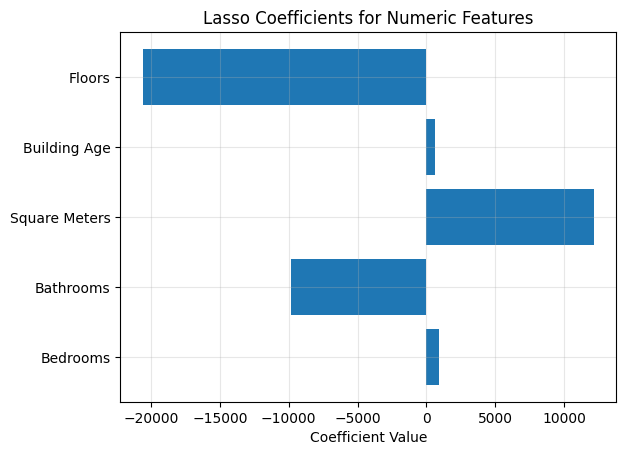

In [39]:
lasso_coeff1 = lasso_num.fit(X_train_numeric, y_train_numeric).coef_

plt.barh(numeric_columns, lasso_coeff1)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

#### 2.6.2 After Scaling

In [40]:
scaler1 = StandardScaler()
scaled_data1 = scaler1.fit_transform(X_train_numeric)

PCA after scaling

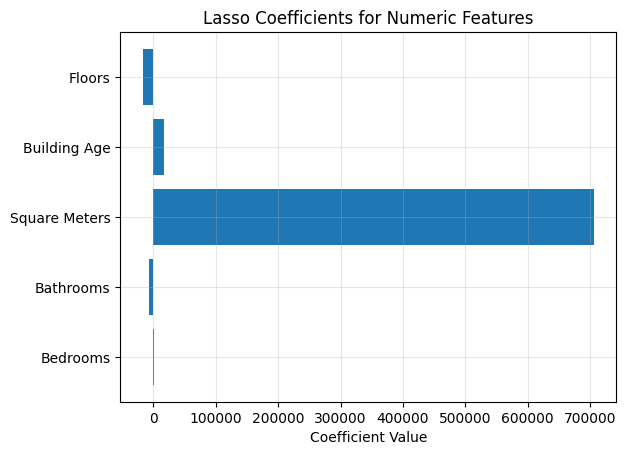

In [41]:
lasso_coeff2 = lasso_num.fit(scaled_data1, y_train_numeric).coef_

plt.barh(numeric_columns, lasso_coeff2)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

### 2.7 Summary
1. Simple models - same performance as when using just Square Meters (R2=0.59)
2. Cross-validation - same performance as... ()
3. Hyperparameter tuning - same performance as...
4. Scaling - nothing gained
5. PCA - as expected Square Meters has the biggest effect after scaling (if you don't apply scaling then floors and bathrooms have massive negative coefficients).
6. Lasso, Ridge and LinReg still all the same

## -------------------- Pass 3 - Adding Neighbourhood data --------------------
As well as the numeric data, we now add categoric data: the neighbourhood of each house.

This requires converting the categoric data to numeric data.

This is expected to improve accuracy - from the EDA, the neighbourhoods were quite strongly correlated to the Price.

### 3.1 Get Data
How many instances are there of each neighborhood?

In [42]:
print(housing_df['Neighborhood'].unique())
for neighborhood in housing_df['Neighborhood'].unique():
    print(f'{neighborhood}: {len(housing_df[housing_df["Neighborhood"] == neighborhood])}')

['Notting Hill' 'Westminster' 'Soho' 'Islington' 'Marylebone' 'Kensington'
 'Greenwich' 'Shoreditch' 'Camden' 'Chelsea']
Notting Hill: 96
Westminster: 98
Soho: 96
Islington: 97
Marylebone: 113
Kensington: 114
Greenwich: 97
Shoreditch: 89
Camden: 106
Chelsea: 94


Create dummy variables for the neighborhood columns.

In [43]:
neighborhoods = housing_df['Neighborhood'].unique()
print(neighborhoods, len(neighborhoods))

# Create dummy variables for neighborhoods
neighborhood_dummies = pd.get_dummies(housing_df['Neighborhood'], drop_first=True).astype('int')
neighbor_numeric_df = pd.concat([housing_df[numeric_columns], neighborhood_dummies], axis=1)
# neighbor_numeric_df = pd.get_dummies(housing_df[numeric_columns+['Neighborhood']], drop_first=True)
neighbor_numeric_df.head()

['Notting Hill' 'Westminster' 'Soho' 'Islington' 'Marylebone' 'Kensington'
 'Greenwich' 'Shoreditch' 'Camden' 'Chelsea'] 10


,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Chelsea,Greenwich,Islington,Kensington,Marylebone,Notting Hill,Shoreditch,Soho,Westminster
0,2,3,179,72,3,0,0,0,0,0,1,0,0,0
1,2,1,123,34,1,0,0,0,0,0,0,0,0,1
2,5,3,168,38,3,0,0,0,0,0,0,0,1,0
3,5,1,237,53,1,0,0,1,0,0,0,0,0,0
4,4,1,127,23,2,0,0,0,0,1,0,0,0,0


Create test and training data

In [44]:
X_train_neighbor, X_test_neighbor, y_train_neighbor, y_test_neighbor = train_test_split(neighbor_numeric_df, y, test_size=0.3, random_state=24)

print(X_train_neighbor.shape, X_test_neighbor.shape, y_train_neighbor.shape, y_test_neighbor.shape)

(700, 14) (300, 14) (700,) (300,)


### 3.2 Simple Models

#### 3.2.1 Import, instantiate, fit

Linear, lasso and ridge regression model

In [45]:
# Instantiate models
linreg_neighbor = LinearRegression()
lasso_neighbor = Lasso(alpha = 0.1)
ridge_neighbor = Ridge(alpha = 0.1)

# Fit to neighbor data
linreg_neighbor.fit(X_train_neighbor, y_train_neighbor)
lasso_neighbor.fit(X_train_neighbor, y_train_neighbor)
ridge_neighbor.fit(X_train_neighbor, y_train_neighbor)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [46]:
# Create a dictionary of neighboreric models
models_neighbor = {
    'Linear Regression': linreg_neighbor,
    'Lasso': lasso_neighbor,
    'Ridge': ridge_neighbor
}

#### 3.2.2 Predict & Plot

Linear Regression training--testing R²: 0.8325--0.8249
Lasso training--testing R²: 0.8325--0.8249
Ridge training--testing R²: 0.8325--0.8247


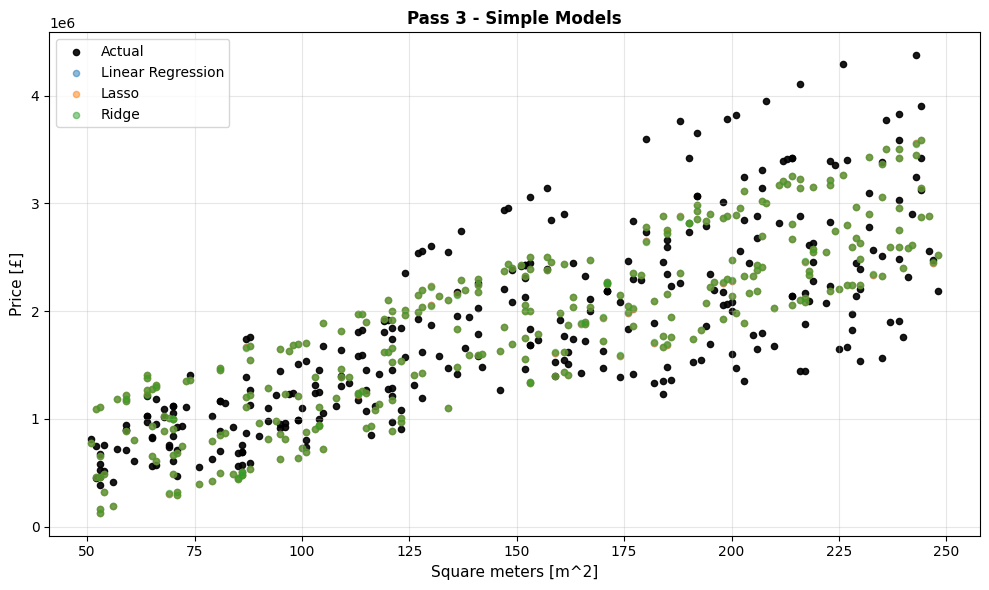

In [47]:
score_predict_plot(models_neighbor,
                   X_train_neighbor, y_train_neighbor, X_test_neighbor, y_test_neighbor,
                   X_test_sqm, title='Pass 3 - Simple Models')

### 3.3 Cross validation
Training set scores

In [48]:
cross_vals_neighbor_train = multi_cross_val_score(
    models = models_neighbor,
    X = X_train_neighbor,
    y = y_train_neighbor,
    kf = kf10
)

Linear Regression cross-validation scores: 0.78 --- 0.822 --- 0.872
Lasso cross-validation scores: 0.78 --- 0.822 --- 0.872
Ridge cross-validation scores: 0.78 --- 0.822 --- 0.872


Test set scores

In [49]:
cross_vals_neighbor_test = multi_cross_val_score(
    models = models_neighbor,
    X = X_test_neighbor,
    y = y_test_neighbor,
    kf = kf10
)

Linear Regression cross-validation scores: 0.769 --- 0.808 --- 0.857
Lasso cross-validation scores: 0.769 --- 0.808 --- 0.857
Ridge cross-validation scores: 0.768 --- 0.808 --- 0.858


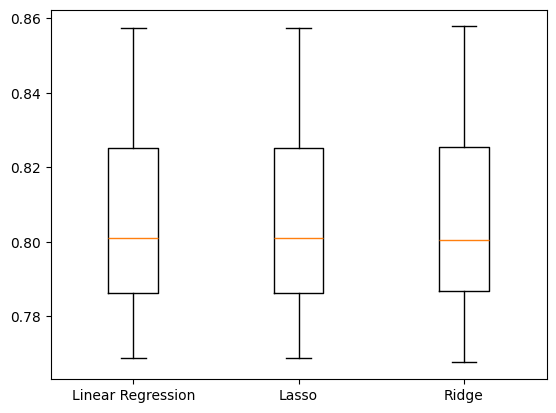

In [50]:
plt.boxplot(
    [model_result for model_result in cross_vals_neighbor_test.values()],
    labels = [model_name for model_name in cross_vals_neighbor_test.keys()]
)
plt.show()

### 3.4 Hyperparameter Tuning

For this data, the Ridge model fails to converge so is commented out here.

In [51]:
# Instantiate GridSearchCVs
gridCV_lasso_neighbor = GridSearchCV(lasso_neighbor, lasso_params, cv=kf10)
gridCV_ridge_neighbor = GridSearchCV(lasso_neighbor, ridge_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_neighbor = RandomizedSearchCV(lasso_neighbor, lasso_params, cv=kf10, n_iter=10, random_state=24)
# randomCV_ridge_neighbor = RandomizedSearchCV(ridge_neighbor, ridge_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_neighbor = {'Lasso GridSearchCV': gridCV_lasso_neighbor,
                # 'Ridge GridSearchCV': gridCV_ridge_neighbor,
                'Lasso RandomizedSearchCV': randomCV_lasso_neighbor,
                # 'Ridge RandomizedSearchCV': randomCV_ridge_neighbor
                }

In [52]:
cvs_neighbor = evaluate_CVs(cvs_neighbor, X_train_neighbor, y_train_neighbor)

----- Lasso GridSearchCV -----
Top score: 0.8222
Top params: {'alpha': 10.0}
----- Lasso RandomizedSearchCV -----
Top score: 0.8222
Top params: {'alpha': 8.163448979591838}


### 3.5 Scaling

In [53]:
steps_neighbor = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge_neighbor = Pipeline(steps_neighbor)

ridge_neighbor_scaled = pipeline_ridge_neighbor.fit(X_train_neighbor, y_train_neighbor)

In [54]:
ridge_neighbor_scaled.score(X_test_neighbor, y_test_neighbor)

0.8248280330569018

In [55]:
# Create a RandomizedSearchCV with pipelines
ridge_neighbor_params = {'ridge__alpha': np.linspace(0.001, 10, 100),
                         'ridge__solver': ['sag', 'lsqr']}
randomCV_ridge_neighbor_scaled = RandomizedSearchCV(pipeline_ridge_neighbor, param_distributions=ridge_neighbor_params,
                                                    cv=kf10, n_iter=20, random_state=24)

randomCV_ridge_neighbor_scaled.fit(X_train_neighbor, y_train_neighbor)

,estimator,"Pipeline(step...e', Ridge())])"
,param_distributions,"{'ridge__alpha': array([1.000e...0, 1.000e+01]), 'ridge__solver': ['sag', 'lsqr']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


In [56]:
# Score RandomizedSearchCV models
print(f'Ridge TRAIN score: {randomCV_ridge_neighbor_scaled.score(X_train_neighbor, y_train_neighbor)}')
print(f'Ridge TEST score: {randomCV_ridge_neighbor_scaled.score(X_test_neighbor, y_test_neighbor)}')
print(f'Scaled Ridge GridSearchCV top score: {randomCV_ridge_neighbor_scaled.best_score_} from {randomCV_ridge_neighbor_scaled.best_params_}')

Ridge TRAIN score: 0.8323596043414542
Ridge TEST score: 0.8244647203104686
Scaled Ridge GridSearchCV top score: 0.8224489656686089 from {'ridge__solver': 'sag', 'ridge__alpha': 7.172000000000001}


### 3.6 PCA
Before scaling

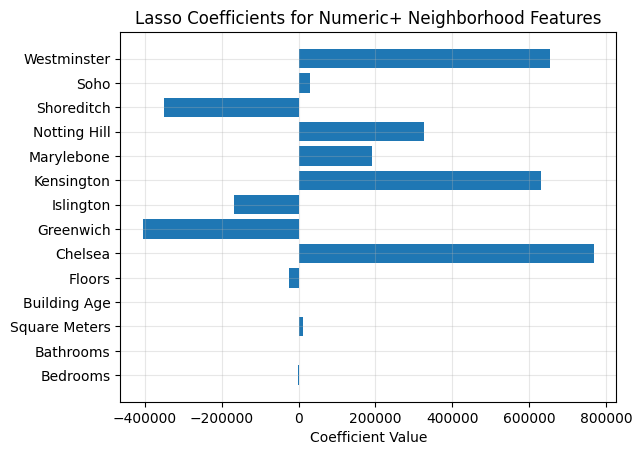

In [57]:
lasso_coeff_neighbor = Lasso(alpha = 0.1).fit(X_train_neighbor, y_train_neighbor).coef_

# lasso_coeff_neighbor
# X_train_neighbor.columns
plt.barh(X_train_neighbor.columns, lasso_coeff_neighbor)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric+ Neighborhood Features')
plt.grid(True, alpha=0.3)
plt.show()

After scaling

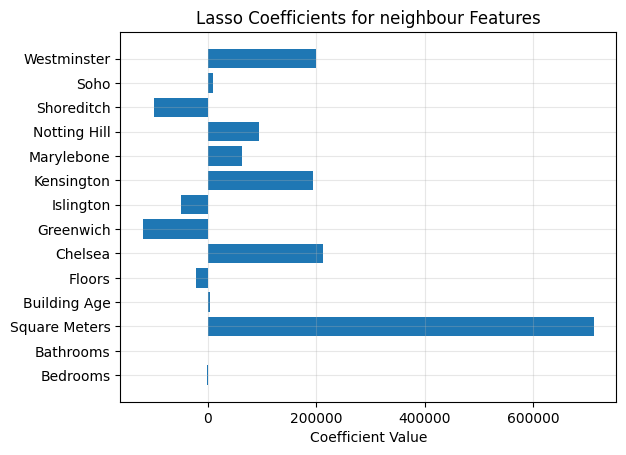

In [58]:
scaled_neighbor = scaler1.fit_transform(X_train_neighbor)
lasso_coeff_neighbor_scaled = Lasso(alpha = 0.1).fit(scaled_neighbor, y_train_neighbor).coef_

plt.barh(X_train_neighbor.columns, lasso_coeff_neighbor_scaled)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for neighbour Features')
plt.grid(True, alpha=0.3)
plt.show()

### 3.7 Summary
1. Neighborhood data - around 90-110 for each of the 10 neighborhoods
2. Simple models - already a ~20% improvement from using numeric data (R^2=0.82).
3. Cross-validation - R^2 range of 0.78-0.87: ~20% improvement on numeric data.
4. Hyperparameter Tuning
    - Best performance of R^2=0.82 for GridSearchCV and RandomizedSearchCV
    - Ridge model has problems with convergence, likely due to the sparse neighborhood data.
5. Scaling - Accuracy is unchanged by scaling but the Ridge model is now able to converge.
6. PCA - Before scaling the neighborhood features have the largest coefficients - after scaling square meters is again back to the top (twice as high as the highest neighborhood coefficient), but neighborhood features still have significantly higher coefficients than the other numeric columns.


## -------------------- Pass 4 - Adding all remaining --------------------
Finally we include all other categoric columns (except Address)

### 4.1 Get Data
We create dummy variables for the remaining columns: bedrooms, bathrooms, building age, garden, garage, floors, property type, heating type, baclony, interior style, view, materials, building status.

Let's check what unique values each categoric column has:

In [59]:
categoric_columns = ['Neighborhood', 'Garden', 'Garage', 'Property Type',
                     'Heating Type', 'Balcony', 'Interior Style', 'View',
                     'Materials', 'Building Status']
# Print unique values for each categoric column
for col in categoric_columns:
    print(f'{len(housing_df[col].unique())} \'{col}\' values: {housing_df[col].unique()}')

10 'Neighborhood' values: ['Notting Hill' 'Westminster' 'Soho' 'Islington' 'Marylebone' 'Kensington'
 'Greenwich' 'Shoreditch' 'Camden' 'Chelsea']
2 'Garden' values: ['No' 'Yes']
2 'Garage' values: ['No' 'Yes']
3 'Property Type' values: ['Semi-Detached' 'Apartment' 'Detached House']
4 'Heating Type' values: ['Electric Heating' 'Central Heating' 'Underfloor Heating' 'Gas Heating']
3 'Balcony' values: ['High-level Balcony' 'No Balcony' 'Low-level Balcony']
4 'Interior Style' values: ['Industrial' 'Classic' 'Modern' 'Minimalist']
5 'View' values: ['Garden' 'City' 'Street' 'Park' 'Sea']
4 'Materials' values: ['Marble' 'Laminate Flooring' 'Wood' 'Granite']
3 'Building Status' values: ['Renovated' 'Old' 'New']


Create dataframe with dummy variables.

In [60]:
# Create dummy variables and convert them to integers
categoric_dummies = pd.get_dummies(housing_df[categoric_columns], drop_first=True).astype('int')
all_df = pd.concat([housing_df[numeric_columns], categoric_dummies], axis=1)
all_df.head()

,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Neighborhood_Chelsea,Neighborhood_Greenwich,Neighborhood_Islington,Neighborhood_Kensington,Neighborhood_Marylebone,...,Interior Style_Modern,View_Garden,View_Park,View_Sea,View_Street,Materials_Laminate Flooring,Materials_Marble,Materials_Wood,Building Status_Old,Building Status_Renovated
0,2,3,179,72,3,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,2,1,123,34,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,5,3,168,38,3,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,5,1,237,53,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,4,1,127,23,2,0,0,0,0,1,...,1,0,1,0,0,0,0,1,1,0


Create test and training data

In [61]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_df, y, test_size=0.3, random_state=24)

print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)

(700, 35) (300, 35) (700,) (300,)


### 4.2 Simple Models
#### 4.2.1 Import, instantiate, fit

Linear, lasso and ridge regression model

In [62]:
# Instantiate models
linreg_all = LinearRegression()
lasso_all = Lasso(alpha = 0.1)
ridge_all = Ridge(alpha = 0.1)

# Fit to all data
linreg_all.fit(X_train_all, y_train_all)
# lasso_all.fit(X_train_all, y_train_all)
ridge_all.fit(X_train_all, y_train_all)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [63]:
# Create a dictionary of alleric models
models_all = {
    'Linear Regression': linreg_all,
    # 'Lasso': lasso_all,
    'Ridge': ridge_all
}

#### 4.2.2 Predict & Plot

Linear Regression training--testing R²: 0.9498--0.9430
Ridge training--testing R²: 0.9498--0.9430


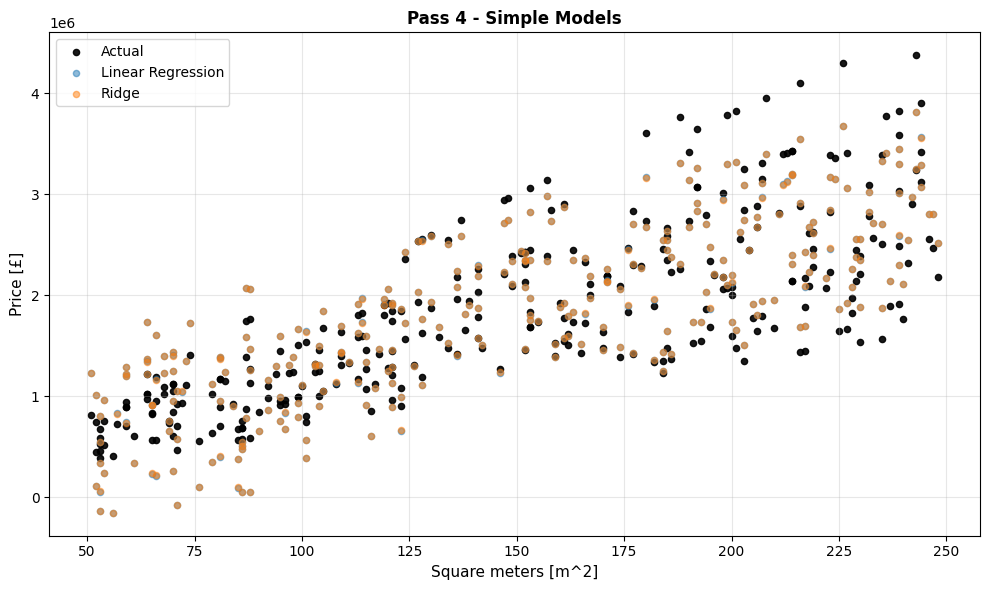

In [64]:
score_predict_plot(models_all,
                   X_train_all, y_train_all, X_test_all, y_test_all,
                   X_test_sqm, title='Pass 4 - Simple Models')

### 4.3 Cross validation
Training set scores

In [65]:
cross_vals_all_train = multi_cross_val_score(
    models = models_all,
    X = X_train_all,
    y = y_train_all,
    kf = kf10
)

Linear Regression cross-validation scores: 0.916 --- 0.943 --- 0.959
Ridge cross-validation scores: 0.916 --- 0.943 --- 0.959


Test set secores

In [66]:
cross_vals_all_test = multi_cross_val_score(
    models = models_all,
    X = X_test_all,
    y = y_test_all,
    kf = kf10
)

Linear Regression cross-validation scores: 0.912 --- 0.935 --- 0.953
Ridge cross-validation scores: 0.912 --- 0.935 --- 0.952


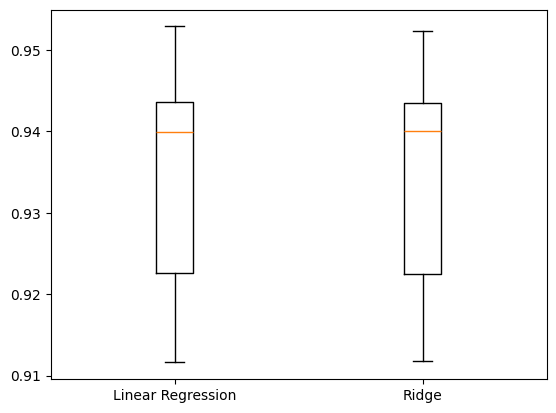

In [67]:
plt.boxplot(
    [model_result for model_result in cross_vals_all_test.values()],
    labels = [model_name for model_name in cross_vals_all_test.keys()]
)
plt.show()

### 4.4 Scaling

Skip straight to scaling this time.

In [68]:
steps_linreg = [('scaler', StandardScaler()),
                  ('lasso', LinearRegression())]
steps_lasso = [('scaler', StandardScaler()),
                  ('lasso', Lasso())]
steps_ridge = [('scaler', StandardScaler()),
                  ('ridge', Ridge())]

pipeline_linreg_all_scaled = Pipeline(steps_linreg)
pipeline_lasso_all_scaled = Pipeline(steps_lasso)
pipeline_ridge_all_scaled = Pipeline(steps_ridge)

pipeline_linreg_all_scaled.fit(X_train_all, y_train_all)
pipeline_lasso_all_scaled.fit(X_train_all, y_train_all)
pipeline_ridge_all_scaled.fit(X_train_all, y_train_all)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


LinReg (scaled) training--testing R²: 0.9498--0.9430
Lasso (scaled) training--testing R²: 0.9498--0.9430
Ridge (scaled) training--testing R²: 0.9498--0.9430


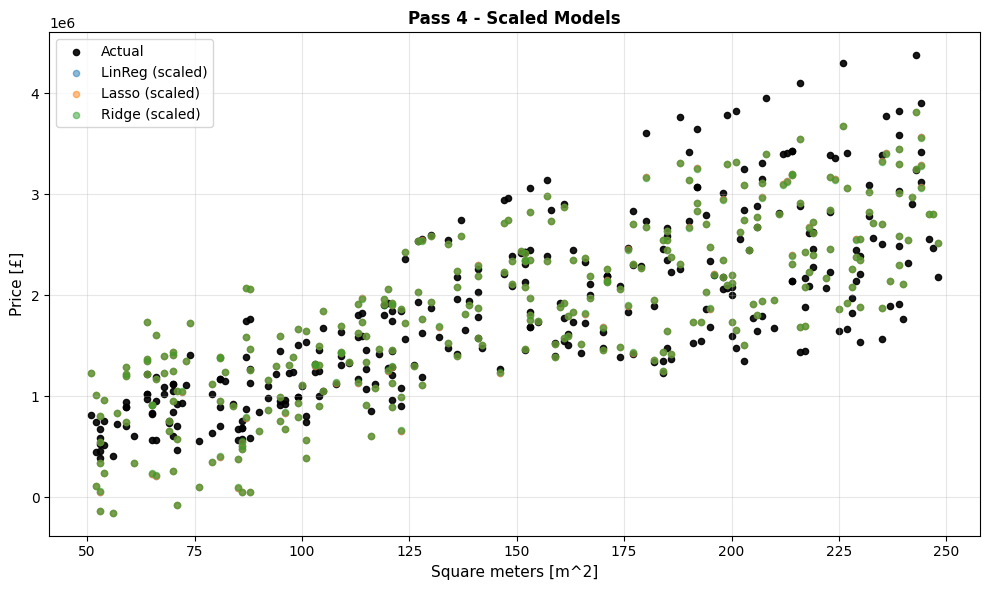

In [69]:
score_predict_plot({'LinReg (scaled)': pipeline_linreg_all_scaled, 
                    'Lasso (scaled)': pipeline_lasso_all_scaled, 
                    'Ridge (scaled)': pipeline_ridge_all_scaled},
                   X_train_all, y_train_all, X_test_all, y_test_all,
                   X_test_sqm, title='Pass 4 - Scaled Models')

### 4.5 Hyperparameter tuning

In [71]:
# Create hyperparameter grids
lasso_all_params = {'lasso__alpha': np.linspace(0.001, 10, 100)}
ridge_all_params = {'ridge__alpha': np.linspace(0.001, 10, 100),
                    'ridge__solver': ['sag', 'lsqr']}
# Instantiate GridSearchCVs
gridCV_lasso_all = GridSearchCV(pipeline_lasso_all_scaled, lasso_all_params, cv=kf10)
gridCV_ridge_all = GridSearchCV(pipeline_ridge_all_scaled, ridge_all_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_all = RandomizedSearchCV(pipeline_lasso_all_scaled, lasso_all_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge_all = RandomizedSearchCV(pipeline_ridge_all_scaled, ridge_all_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_all = {'Lasso GridSearchCV': gridCV_lasso_all,
            'Ridge GridSearchCV': gridCV_ridge_all,
            'Lasso RandomizedSearchCV': randomCV_lasso_all,
            'Ridge RandomizedSearchCV': randomCV_ridge_all
            }

In [72]:
cvs_results_all = evaluate_CVs(cvs_all, X_train_all, y_train_all)

----- Lasso GridSearchCV -----
Top score: 0.9427
Top params: {'lasso__alpha': 10.0}
----- Ridge GridSearchCV -----
Top score: 0.9428
Top params: {'ridge__alpha': 3.334, 'ridge__solver': 'sag'}
----- Lasso RandomizedSearchCV -----
Top score: 0.9427
Top params: {'lasso__alpha': 8.889}
----- Ridge RandomizedSearchCV -----
Top score: 0.9428
Top params: {'ridge__solver': 'lsqr', 'ridge__alpha': 5.051000000000001}


### 4.6 PCA
Before scaling

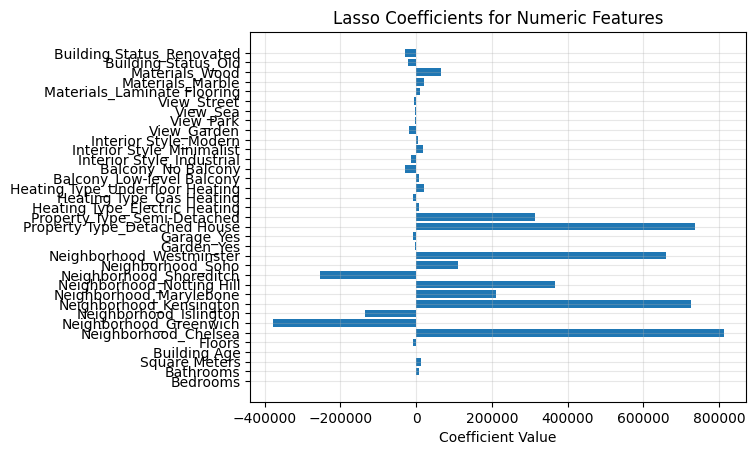

In [73]:
lasso_coeff_all = Lasso(alpha = 0.1).fit(X_train_all, y_train_all).coef_

# lasso_coeff_neighbor
# X_train_neighbor.columns
plt.barh(X_train_all.columns, lasso_coeff_all)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

After scaling - first, sort columns by those with the largest coefficients

In [74]:
scaled_all = scaler1.fit_transform(X_train_all)
lasso_coeff_all_scaled = Lasso(alpha = 0.1).fit(scaled_all, y_train_all).coef_

lasso_coef_df = pd.DataFrame([X_train_all.columns, lasso_coeff_all_scaled]).transpose()
lasso_coef_df.columns=['Features', 'Coefficients']
lasso_coef_df['Abs. Coeff.'] = np.abs(lasso_coef_df['Coefficients'])
lasso_coef_df.sort_values('Abs. Coeff.', ascending=False).reset_index(drop=True)

,Features,Coefficients,Abs. Coeff.
0,Square Meters,706608.369933,706608.369933
1,Property Type_Detached House,352637.916023,352637.916023
2,Neighborhood_Chelsea,225578.792226,225578.792226
3,Neighborhood_Kensington,223535.164269,223535.164269
4,Neighborhood_Westminster,201952.860251,201952.860251
5,Property Type_Semi-Detached,148587.803579,148587.803579
6,Neighborhood_Greenwich,-111573.427194,111573.427194
7,Neighborhood_Notting Hill,107477.583803,107477.583803
8,Neighborhood_Shoreditch,-71299.250243,71299.250243
9,Neighborhood_Marylebone,70505.763151,70505.763151


Next, plot the coefficients.

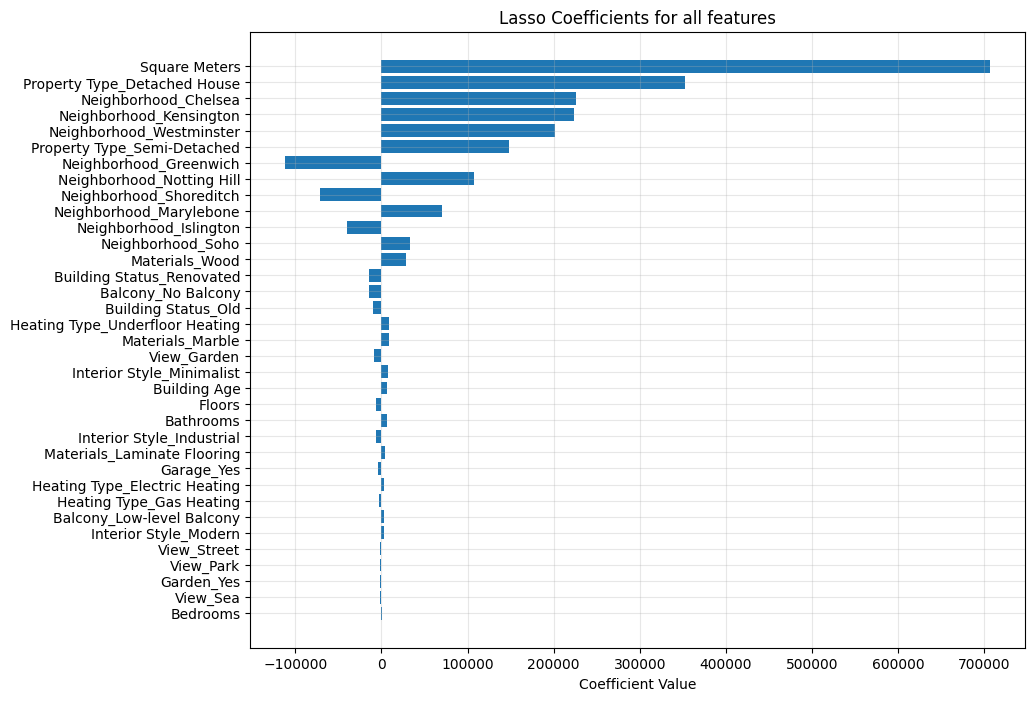

In [75]:
plt.figure(figsize=(10, 8))
plt.barh(lasso_coef_df.sort_values('Abs. Coeff.')['Features'],
         lasso_coef_df.sort_values('Abs. Coeff.')['Coefficients'])
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for all features')
plt.grid(True, alpha=0.3)
plt.show()

### 4.7 Summary
1. Overall:
    - Lasso model fails to converge on the standard parameters.
    - Linear, Lasso and Ridge regression all basically still perform the same.
2. Simple models - already a ~10% improvement from using neighborhood data (R^2=0.94).
3. Cross-validation - R^2 range of 0.92-0.96: ~10% improvement on neighborhood data and a tighter range.
4. Scaling - Accuracy is unchanged by scaling but the Lasso model is now able to converge.
5. Hyperparameter Tuning
    - Best performance of R^2=0.94 for GridSearchCV and RandomizedSearchCV
    - The cell doing the hyperparameter tuning now takes ~30s to complete (working on 4 models - Grid & Randomized CVs on Ridge& Lasso)
6. PCA
    - Top coefficient still belongs to 'Square Meters' by a distance
    - The Property Type (Detached vs. Semi-D, vs. Apartment) also rank highly
    - All the neighborhood values are in the top 13, rounded out by 'Materials_Wood'.
    - The number of Bedrooms has the smallest coefficient.

## -------------------- Pass 5 - Top Features --------------------
Include the top 13 features from the PCA in Pass 4 and see if the models can be run without losing accuracy.

### 5.1 Get Data

In [76]:
top_columns = ['Square Meters',
 'Property Type_Detached House',
 'Neighborhood_Chelsea',
 'Neighborhood_Kensington',
 'Neighborhood_Westminster',
 'Property Type_Semi-Detached',
 'Neighborhood_Greenwich',
 'Neighborhood_Notting Hill',
 'Neighborhood_Shoreditch',
 'Neighborhood_Marylebone',
 'Neighborhood_Islington',
 'Neighborhood_Soho',
 'Materials_Wood']
top_columns_df = all_df[top_columns]
top_columns_df.head()

,Square Meters,Property Type_Detached House,Neighborhood_Chelsea,Neighborhood_Kensington,Neighborhood_Westminster,Property Type_Semi-Detached,Neighborhood_Greenwich,Neighborhood_Notting Hill,Neighborhood_Shoreditch,Neighborhood_Marylebone,Neighborhood_Islington,Neighborhood_Soho,Materials_Wood
0,179,0,0,0,0,1,0,1,0,0,0,0,0
1,123,0,0,0,1,0,0,0,0,0,0,0,0
2,168,0,0,0,0,1,0,0,0,0,0,1,1
3,237,0,0,0,0,0,0,0,0,0,1,0,0
4,127,0,0,0,0,1,0,0,0,1,0,0,1


In [77]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(top_columns_df, y, test_size=0.3, random_state=24)

print(X_train_top.shape, X_test_top.shape, y_train_top.shape, y_test_top.shape)

(700, 13) (300, 13) (700,) (300,)


### 5.2 Scaled models

In [78]:
pipeline_linreg_top_scaled = Pipeline(steps_linreg)
pipeline_lasso_top_scaled = Pipeline(steps_lasso)
pipeline_ridge_top_scaled = Pipeline(steps_ridge)

pipeline_linreg_top_scaled.fit(X_train_top, y_train_top)
pipeline_lasso_top_scaled.fit(X_train_top, y_train_top)
pipeline_ridge_top_scaled.fit(X_train_top, y_train_top)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [79]:
models_top = {'LinReg (scaled)': pipeline_linreg_top_scaled, 
              'Lasso (scaled)': pipeline_lasso_top_scaled, 
              'Ridge (scaled)': pipeline_ridge_top_scaled}

LinReg (scaled) training--testing R²: 0.9487--0.9445
Lasso (scaled) training--testing R²: 0.9487--0.9445
Ridge (scaled) training--testing R²: 0.9487--0.9445


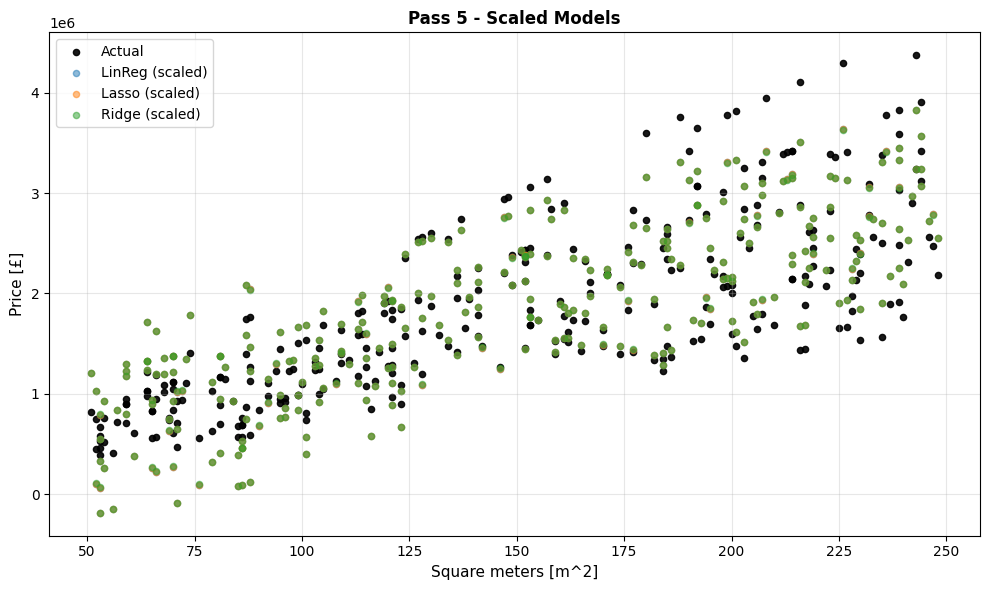

In [ ]:
score_predict_plot(models_top,
                   X_train_top, y_train_top, X_test_top, y_test_top,
                   X_test_sqm, title='Top features only - Simple Models')

### 5.3 Cross validation

In [81]:
cross_vals_top_train = multi_cross_val_score(
    models = models_top,
    X = X_train_top,
    y = y_train_top,
    kf = kf10
)

LinReg (scaled) cross-validation scores: 0.917 --- 0.946 --- 0.966
Lasso (scaled) cross-validation scores: 0.917 --- 0.946 --- 0.966
Ridge (scaled) cross-validation scores: 0.917 --- 0.946 --- 0.966


In [82]:
cross_vals_top_test = multi_cross_val_score(
    models = models_top,
    X = X_test_top,
    y = y_test_top,
    kf = kf10
)

LinReg (scaled) cross-validation scores: 0.921 --- 0.939 --- 0.958
Lasso (scaled) cross-validation scores: 0.921 --- 0.939 --- 0.958
Ridge (scaled) cross-validation scores: 0.922 --- 0.939 --- 0.958


### 5.4 Hyperparameter tuning


In [109]:
# Instantiate GridSearchCVs
gridCV_lasso_top = GridSearchCV(pipeline_lasso_top_scaled, lasso_all_params, cv=kf10)
gridCV_ridge_top = GridSearchCV(pipeline_ridge_top_scaled, ridge_all_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_top = RandomizedSearchCV(pipeline_lasso_top_scaled, lasso_all_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge_top = RandomizedSearchCV(pipeline_ridge_top_scaled, ridge_all_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_top = {'Lasso GridSearchCV': gridCV_lasso_top,
            'Ridge GridSearchCV': gridCV_ridge_top,
            'Lasso RandomizedSearchCV': randomCV_lasso_top,
            'Ridge RandomizedSearchCV': randomCV_ridge_top
            }

In [ ]:
cvs_results_top = evaluate_CVs(cvs_all, X_train_all, y_train_all)

Success! These models remain 94% accurate using only the best features.

## Extra 1 - Using all the worst coefficients
What if we used all the feature _except_ the top 13? Will the model do worse, and if so by how much?

In [93]:
bottom_columns = ['Building Status_Renovated',
 'Balcony_No Balcony',
 'Building Status_Old',
 'Heating Type_Underfloor Heating',
 'Materials_Marble',
 'View_Garden',
 'Interior Style_Minimalist',
 'Building Age',
 'Floors',
 'Bathrooms',
 'Interior Style_Industrial',
 'Materials_Laminate Flooring',
 'Garage_Yes',
 'Heating Type_Electric Heating',
 'Heating Type_Gas Heating',
 'Balcony_Low-level Balcony',
 'Interior Style_Modern',
 'View_Street',
 'View_Park',
 'Garden_Yes',
 'View_Sea',
 'Bedrooms',]
bottom_columns_df = all_df[bottom_columns]
bottom_columns_df.head()

,Building Status_Renovated,Balcony_No Balcony,Building Status_Old,Heating Type_Underfloor Heating,Materials_Marble,View_Garden,Interior Style_Minimalist,Building Age,Floors,Bathrooms,...,Garage_Yes,Heating Type_Electric Heating,Heating Type_Gas Heating,Balcony_Low-level Balcony,Interior Style_Modern,View_Street,View_Park,Garden_Yes,View_Sea,Bedrooms
0,1,0,0,0,1,1,0,72,3,3,...,0,1,0,0,0,0,0,0,0,2
1,0,0,1,0,0,0,0,34,1,1,...,0,0,0,0,0,0,0,1,0,2
2,1,1,0,0,0,0,0,38,3,3,...,1,0,0,0,0,1,0,0,0,5
3,1,1,0,1,0,0,0,53,1,1,...,1,0,0,0,0,0,1,1,0,5
4,0,1,1,0,0,0,0,23,2,1,...,1,0,0,0,1,0,1,0,0,4


In [94]:
X_train_bottom, X_test_bottom, y_train_bottom, y_test_bottom = train_test_split(bottom_columns_df, y, test_size=0.3, random_state=24)

print(X_train_bottom.shape, X_test_bottom.shape, y_train_bottom.shape, y_test_bottom.shape)

(700, 22) (300, 22) (700,) (300,)


In [95]:
pipeline_linreg_bottom_scaled = Pipeline(steps_linreg)
pipeline_lasso_bottom_scaled = Pipeline(steps_lasso)
pipeline_ridge_bottom_scaled = Pipeline(steps_ridge)

pipeline_linreg_bottom_scaled.fit(X_train_bottom, y_train_bottom)
pipeline_lasso_bottom_scaled.fit(X_train_bottom, y_train_bottom)
pipeline_ridge_bottom_scaled.fit(X_train_bottom, y_train_bottom)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [96]:
models_bottom = {'LinReg (scaled)': pipeline_linreg_bottom_scaled, 
                 'Lasso (scaled)': pipeline_lasso_bottom_scaled, 
                 'Ridge (scaled)': pipeline_ridge_bottom_scaled}

LinReg (scaled) training--testing R²: 0.0439---0.0214
Lasso (scaled) training--testing R²: 0.0439---0.0214
Ridge (scaled) training--testing R²: 0.0439---0.0213


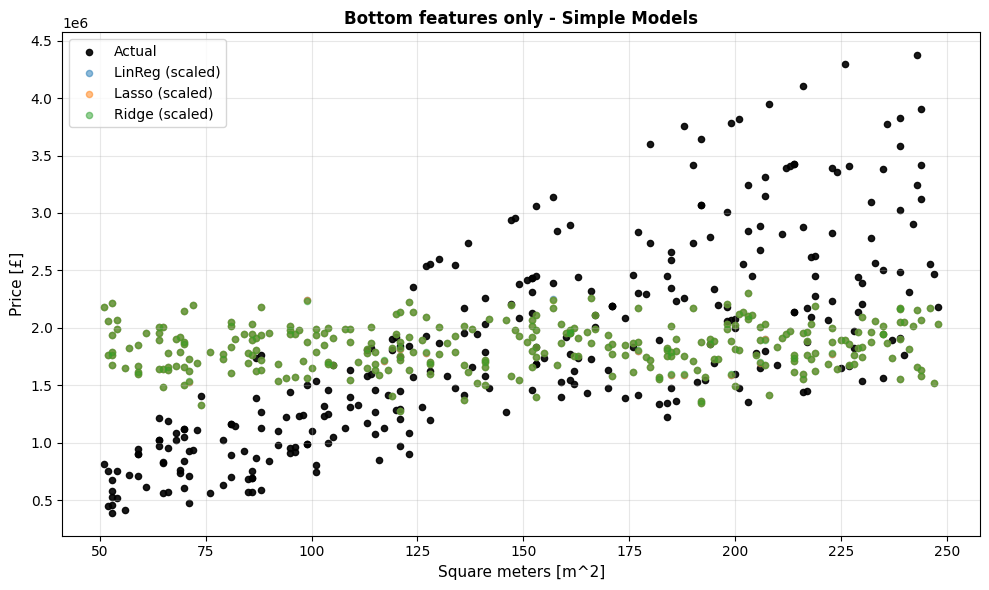

In [97]:
score_predict_plot(models_bottom,
                   X_train_bottom, y_train_bottom, X_test_bottom, y_test_bottom,
                   X_test_sqm, title='Bottom features only - Simple Models')

Woeful!

## Extra 2 - predicting braithwaite house value

In [99]:
# Set Braithwaite house variables
braithwaite_house_16 = {'Address': 'Flat 16 Braithwaite House',
                        'Neighborhood': 'Islington',
                        'Bedrooms': 2,
                        'Bathrooms': 1,
                        'Square Meters': 75,
                        'Building Age': 80,
                        'Garden': 'Yes',
                        'Garage': 'No',
                        'Floors': 2,
                        'Property Type': 'Apartment',
                        'Heating Type': 'Central Heating',
                        'Balcony': 'No Balcony',
                        'Interior Style': 'Modern',
                        'View': 'Park',
                        'Materials': 'Wood',
                        'Building Status': 'Renovated',
                        'Price (£)': 535000}

In [102]:
# Give braithwaite house its own DF
braithwaite_house_16_df = pd.DataFrame.from_records([braithwaite_house_16], index=[1])
# Add Braithwaite house to housing_df
housing_df_plus = pd.concat([housing_df, braithwaite_house_16_df])
housing_df_plus.tail()

,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
996,165 Park Lane,Camden,1,1,65,51,No,No,1,Apartment,Underfloor Heating,No Balcony,Industrial,Garden,Wood,Old,563333
997,99 Camden High Street,Camden,4,1,191,27,No,Yes,2,Semi-Detached,Central Heating,Low-level Balcony,Minimalist,Park,Laminate Flooring,Old,1986399
998,155 Park Lane,Camden,5,2,131,3,Yes,No,2,Detached House,Underfloor Heating,High-level Balcony,Modern,Park,Laminate Flooring,Renovated,1703000
999,145 Baker Street,Kensington,4,2,185,53,No,No,1,Apartment,Electric Heating,No Balcony,Modern,Street,Wood,Old,2343333
1,Flat 16 Braithwaite House,Islington,2,1,75,80,Yes,No,2,Apartment,Central Heating,No Balcony,Modern,Park,Wood,Renovated,535000


In [103]:
# Convert new housing_df categoric data to integers
housing_df_plus_dummies = pd.get_dummies(housing_df_plus[categoric_columns], drop_first=True).astype('int')
# Combine new housing_df categoric dat and with numeric data
housing_df_plus_all = pd.concat([housing_df_plus[numeric_columns], housing_df_plus_dummies], axis=1)
housing_df_plus_all.tail()

,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Neighborhood_Chelsea,Neighborhood_Greenwich,Neighborhood_Islington,Neighborhood_Kensington,Neighborhood_Marylebone,...,Interior Style_Modern,View_Garden,View_Park,View_Sea,View_Street,Materials_Laminate Flooring,Materials_Marble,Materials_Wood,Building Status_Old,Building Status_Renovated
996,1,1,65,51,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
997,4,1,191,27,2,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
998,5,2,131,3,2,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
999,4,2,185,53,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
1,2,1,75,80,2,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,1


In [108]:
# Make predictions for Braithwaite house
print(linreg_all.predict(housing_df_plus_all.iloc[-2:]))
# print(lasso_all.predict(housing_df_plus_all.iloc[-2:]))
print(ridge_all.predict(housing_df_plus_all.iloc[-2:]))

[2451385.02358069  220736.12144366]
[2450929.37257032  221566.01598792]
